# Automatic emittance measurement at LCLS
In this case we have 4 quadrupoles, 3 that are used to minimize the incoming beam and
 the fourth to perform the quad scan measurement.

In [1]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../../")

import xopt
print(xopt.__version__)


# set up data saving locations
data_dir = "/home/physics3/ml_tuning/20230729_LCLS_Injector"

run_name = "optimize_1"
run_dir = f"{data_dir}/{run_name}"
import os
if not os.path.exists(run_dir):
    os.mkdir(run_dir)
    


2.0a1+47.g1d5b3d1


In [2]:
from scripts.evaluate_function.screen_image import measure_beamsize, measure_background
from scripts.optimize_function import optimize_function
from scripts.characterize_emittance import characterize_emittance

In [3]:
## import variable ranges
import pandas as pd
filename = "../../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')
SCREEN_NAME = "OTRS:IN20:621" # OTR 3

## (Optional) Measure background image

In [4]:
MEASURE_BACKGROUND = False
BACKGROUND_FILE = f"{data_dir}/{SCREEN_NAME}_background.npy".replace(":","_")

if MEASURE_BACKGROUND:
    measure_background(SCREEN_NAME, filename=BACKGROUND_FILE)


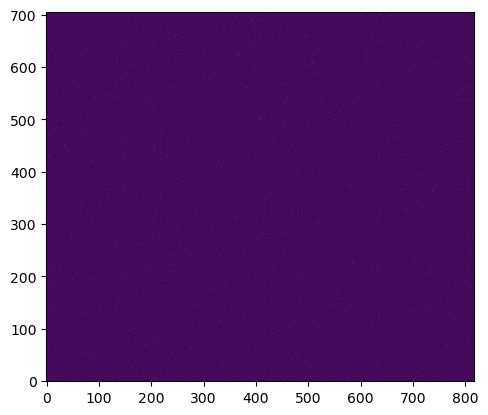

In [5]:
# verify background image
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.load(BACKGROUND_FILE),origin="lower")

## reset point

## Define measurement parameters

In [7]:
from xopt import VOCS
import numpy as np
import json


TUNING_VARIABLES = ["QUAD:IN20:425:BCTRL","QUAD:IN20:441:BCTRL","QUAD:IN20:511:BCTRL"]
SCAN_VARIABLE = "QUAD:IN20:525:BCTRL"
QUAD_LENGTH = 0.108 # m
DRIFT_LENGTH = 4.17 # m
BEAM_ENERGY = 0.135 # GeV
PV_TO_INTEGRATED_GRADIENT = 1.0 # kG
ROI = None

secondary_observables = np.loadtxt("../../secondary_variables.csv", delimiter=",")

measurement_options = {
    "screen": SCREEN_NAME,
    "background": BACKGROUND_FILE,
    "roi": ROI,
    "bb_half_width": 2.0, # half width of the bounding box in terms of std
    "visualize": False,
    "save_img_location": run_dir,
    "sleep_time": 3.0,
    "n_shots": 5,
    "extra_pvs": secondary_observables
}

image_constraints = {
    "bb_penalty": ["LESS_THAN", 0.0],
    "log10_total_intensity": ["GREATER_THAN", 4]
}

# define function to measure the total size on OTR4
def eval_beamsize(input_dict):
    results = measure_beamsize(input_dict)

    # get secondary PV settings/readbacks
    secondary_results = caget_many(secondary_observables)
    results = results | secondary_results

    results["S_x_mm"] = np.array(results["Sx"]) * 1e-3
    results["S_y_mm"] = np.array(results["Sy"]) * 1e-3

    #add total beam size
    xnp = results["S_x_mm"]
    ynp = results["S_y_mm"]
    results["total_size"] = np.sqrt(np.absolute(xnp)*np.absolute(ynp)) + np.absolute(xnp-ynp)
    return results



## Optimize upstream beam parameters to minimze beamsize
Note that the scan variable is fixed at zero for maximum range quadrupole scan.

In [8]:
opt_vocs = VOCS(
        variables = {ele: VARIABLE_RANGES[ele] for ele in TUNING_VARIABLES},
        constants = {SCAN_VARIABLE: 0.0} | measurement_options,
        constraints = image_constraints,
        objectives = {"total_size": "MINIMIZE"}
    )
opt_vocs.dict()


{'variables': {'QUAD:IN20:425:BCTRL': [-3.0, 3.0],
  'QUAD:IN20:441:BCTRL': [-3.0, 3.0],
  'QUAD:IN20:511:BCTRL': [-3.0, 3.0]},
 'constraints': {'bb_penalty': ['LESS_THAN', 0.0],
  'log10_total_intensity': ['GREATER_THAN', 4.0]},
 'objectives': {'total_size': 'MINIMIZE'},
 'constants': {'QUAD:IN20:525:BCTRL': 0.0,
  'screen': 'OTRS:IN20:621',
  'background': '/home/physics3/ml_tuning/20230729_LCLS_Injector/OTRS_IN20_621_background.npy',
  'threshold': 3,
  'roi': None,
  'bb_half_width': 2.0,
  'visualize': False,
  'save_img_location': '/home/physics3/ml_tuning/20230729_LCLS_Injector/optimize_1',
  'sleep_time': 3.0,
  'n_shots': 5},
 'observables': []}

In [10]:
from epics import caget_many
initial = dict(zip(opt_vocs.variable_names, caget_many(opt_vocs.variable_names)))
initial_pt = pd.DataFrame(initial, index=[0])


In [11]:
opt_x = optimize_function(
    opt_vocs, eval_beamsize, n_iterations=5, initial_points=initial_pt, results_dir=run_dir
)

CAPUT QUAD:IN20:425:BCTRL 1.1240765930393932
CAPUT QUAD:IN20:441:BCTRL -0.8398158246192873
CAPUT QUAD:IN20:511:BCTRL -1.2226495791782455
CAPUT QUAD:IN20:525:BCTRL 0.0
step 0
CAPUT QUAD:IN20:425:BCTRL 2.642903196350164
CAPUT QUAD:IN20:441:BCTRL -2.7935975418771077
CAPUT QUAD:IN20:511:BCTRL 1.854667170447269
CAPUT QUAD:IN20:525:BCTRL 0.0
step 1
CAPUT QUAD:IN20:425:BCTRL 2.665556659505269
CAPUT QUAD:IN20:441:BCTRL -2.8251095661561325
CAPUT QUAD:IN20:511:BCTRL 1.898553189459582
CAPUT QUAD:IN20:525:BCTRL 0.0
step 2
CAPUT QUAD:IN20:425:BCTRL 1.9299022305890783
CAPUT QUAD:IN20:441:BCTRL -1.401892172152857
CAPUT QUAD:IN20:511:BCTRL 1.538579522968911
CAPUT QUAD:IN20:525:BCTRL 0.0
step 3
CAPUT QUAD:IN20:425:BCTRL 1.9132804147540587
CAPUT QUAD:IN20:441:BCTRL -1.3636953725628207
CAPUT QUAD:IN20:511:BCTRL 1.5348557360677397
CAPUT QUAD:IN20:525:BCTRL 0.0
step 4
CAPUT QUAD:IN20:425:BCTRL 1.9162442864133826
CAPUT QUAD:IN20:441:BCTRL -1.3714740969175323
CAPUT QUAD:IN20:511:BCTRL 1.5352605528551024
CAPU

In [12]:
opt_x.data

,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,screen,background,threshold,roi,bb_half_width,visualize,...,Sy,bb_penalty,total_intensity,log10_total_intensity,time,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,1.124077,-0.839816,-1.222650,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,3,None,2.0,False,...,"[nan, 129.12515039835037, 132.15993921799645, ...",225.34575,"[125.79357766861239, 12038.972117072772, 12466...",2.099658,"[1690671068.3365674, 1690671069.7445087, 16906...","[nan, 0.20326574502039335, 0.18965724864674888...","[nan, 0.12912515039835037, 0.13215993921799646...",NaN,10.196460,False
2,1.124077,-0.839816,-1.222650,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,3,None,2.0,False,...,"[nan, 129.12515039835037, 132.15993921799645, ...",-290.795591,"[125.79357766861239, 12038.972117072772, 12466...",4.080589,"[1690671068.3365674, 1690671069.7445087, 16906...","[nan, 0.20326574502039335, 0.18965724864674888...","[nan, 0.12912515039835037, 0.13215993921799646...",0.236149,10.196460,False
3,1.124077,-0.839816,-1.222650,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,3,None,2.0,False,...,"[nan, 129.12515039835037, 132.15993921799645, ...",-290.726484,"[125.79357766861239, 12038.972117072772, 12466...",4.095744,"[1690671068.3365674, 1690671069.7445087, 16906...","[nan, 0.20326574502039335, 0.18965724864674888...","[nan, 0.12912515039835037, 0.13215993921799646...",0.215817,10.196460,False
4,1.124077,-0.839816,-1.222650,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,3,None,2.0,False,...,"[nan, 129.12515039835037, 132.15993921799645, ...",-293.828921,"[125.79357766861239, 12038.972117072772, 12466...",4.08681,"[1690671068.3365674, 1690671069.7445087, 16906...","[nan, 0.20326574502039335, 0.18965724864674888...","[nan, 0.12912515039835037, 0.13215993921799646...",0.217208,10.196460,False
5,1.124077,-0.839816,-1.222650,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,3,None,2.0,False,...,"[nan, 129.12515039835037, 132.15993921799645, ...",-291.553757,"[125.79357766861239, 12038.972117072772, 12466...",4.121913,"[1690671068.3365674, 1690671069.7445087, 16906...","[nan, 0.20326574502039335, 0.18965724864674888...","[nan, 0.12912515039835037, 0.13215993921799646...",0.219906,10.196460,False
6,2.642903,-2.793598,1.854667,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,3,None,2.0,False,...,"[156.84440198700466, 165.19912693559948, 161.2...",-273.365587,"[10793.326167276151, 10620.696209318367, 10777...",4.033155,"[1690671091.984994, 1690671093.366406, 1690671...","[0.16278477288262538, 0.17048977361895123, 0.1...","[0.15684440198700467, 0.1651991269355995, 0.16...",0.165727,9.986523,False
7,2.642903,-2.793598,1.854667,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,3,None,2.0,False,...,"[156.84440198700466, 165.19912693559948, 161.2...",-267.949592,"[10793.326167276151, 10620.696209318367, 10777...",4.026153,"[1690671091.984994, 1690671093.366406, 1690671...","[0.16278477288262538, 0.17048977361895123, 0.1...","[0.15684440198700467, 0.1651991269355995, 0.16...",0.173114,9.986523,False
8,2.642903,-2.793598,1.854667,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,3,None,2.0,False,...,"[156.84440198700466, 165.19912693559948, 161.2...",-268.950017,"[10793.326167276151, 10620.696209318367, 10777...",4.032522,"[1690671091.984994, 1690671093.366406, 1690671...","[0.16278477288262538, 0.17048977361895123, 0.1...","[0.15684440198700467, 0.1651991269355995, 0.16...",0.173234,9.986523,False
9,2.642903,-2.793598,1.854667,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,3,None,2.0,False,...,"[156.84440198700466, 165.19912693559948, 161.2...",-270.788794,"[10793.326167276151, 10620.696209318367, 10777...",3.984374,"[1690671091.984994, 1690671093.366406, 1690671...","[0.16278477288262538, 0.17048977361895123, 0.1...","[0.1568444

<Axes: >

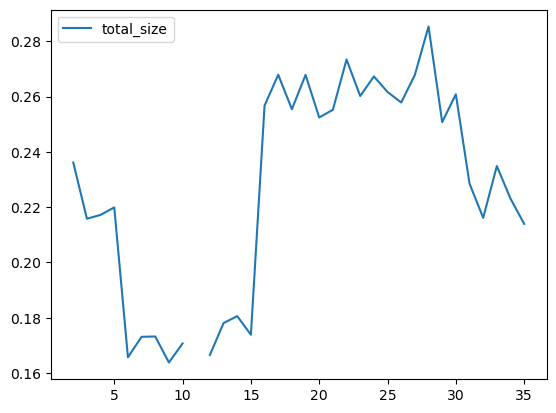

In [13]:
opt_x.data.plot(y="total_size")

<Axes: >

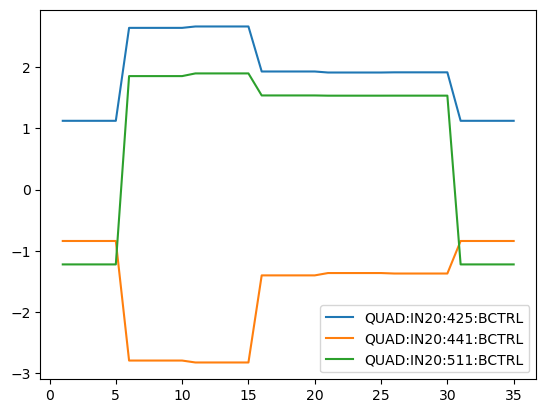

In [14]:
opt_x.data.plot(y=opt_x.vocs.variable_names)

In [15]:
opt_x.data.iloc[-1].to_dict()

{'QUAD:IN20:425:BCTRL': 1.1240765930393932,
 'QUAD:IN20:441:BCTRL': -0.8398158246192873,
 'QUAD:IN20:511:BCTRL': -1.2226495791782455,
 'QUAD:IN20:525:BCTRL': 0.0,
 'screen': 'OTRS:IN20:621',
 'background': '/home/physics3/ml_tuning/20230729_LCLS_Injector/OTRS_IN20_621_background.npy',
 'threshold': 3,
 'roi': None,
 'bb_half_width': 2.0,
 'visualize': False,
 'save_img_location': '/home/physics3/ml_tuning/20230729_LCLS_Injector/optimize_1',
 'sleep_time': 3.0,
 'n_shots': 5,
 'Cx': [380.66228785787905,
  380.24057685857156,
  381.50536893135444,
  379.42175649960086,
  378.4447977514085],
 'Cy': [404.7040507704374,
  405.36774567893997,
  404.79229081470027,
  405.4651285305737,
  405.425590851514],
 'Sx': [199.73722122118625,
  191.8954607765923,
  205.17244024292066,
  194.49772347491793,
  190.80786863799167],
 'Sy': [136.08639621076816,
  139.18904695854786,
  139.44490815420346,
  131.08077618413552,
  140.7101835352448],
 'bb_penalty': -290.49806011083547,
 'total_intensity': [12

## Automatic quad scan

In [ ]:
raise KeyboardInterrupt

In [16]:
from emitopt.utils import get_quad_strength_conversion_factor

run_name = "emit_characterize_1"
run_dir = f"{data_dir}/{run_name}"
import os
if not os.path.exists(run_dir):
    os.mkdir(run_dir)

measurement_options["save_img_location"] = run_dir
measurement_options["n_shots"] = 10

emit_vocs = VOCS(
        variables = {SCAN_VARIABLE: VARIABLE_RANGES[SCAN_VARIABLE]},
        observables = ["S_x_mm", "S_y_mm", "time"],
        constraints = image_constraints,
        constants = opt_x.data.iloc[-1][TUNING_VARIABLES].to_dict() | measurement_options
    )

# create conversion factor from PV value to geometric focusing strength
integrated_gradient_to_geometric_focusing_strength = get_quad_strength_conversion_factor(
        BEAM_ENERGY, QUAD_LENGTH
    )
quad_strength_scale_factor =  PV_TO_INTEGRATED_GRADIENT * integrated_gradient_to_geometric_focusing_strength
emit_vocs

VOCS(variables={'QUAD:IN20:525:BCTRL': [-5.0, 5.0]}, constraints={'bb_penalty': ['LESS_THAN', 0.0], 'log10_total_intensity': ['GREATER_THAN', 4.0]}, objectives={}, constants={'QUAD:IN20:425:BCTRL': 1.1240765930393932, 'QUAD:IN20:441:BCTRL': -0.8398158246192873, 'QUAD:IN20:511:BCTRL': -1.2226495791782455, 'screen': 'OTRS:IN20:621', 'background': '/home/physics3/ml_tuning/20230729_LCLS_Injector/OTRS_IN20_621_background.npy', 'threshold': 3, 'roi': None, 'bb_half_width': 2.0, 'visualize': False, 'save_img_location': '/home/physics3/ml_tuning/20230729_LCLS_Injector/emit_characterize_1', 'sleep_time': 3.0, 'n_shots': 10}, observables=['S_x_mm', 'S_y_mm', 'time'])

CAPUT QUAD:IN20:525:BCTRL -0.9169426258735935
CAPUT QUAD:IN20:425:BCTRL 1.1240765930393932
CAPUT QUAD:IN20:441:BCTRL -0.8398158246192873
CAPUT QUAD:IN20:511:BCTRL -1.2226495791782455
CAPUT QUAD:IN20:525:BCTRL 2.863580561233542
CAPUT QUAD:IN20:425:BCTRL 1.1240765930393932
CAPUT QUAD:IN20:441:BCTRL -0.8398158246192873
CAPUT QUAD:IN20:511:BCTRL -1.2226495791782455
CAPUT QUAD:IN20:525:BCTRL -1.8633788218893468
CAPUT QUAD:IN20:425:BCTRL 1.1240765930393932
CAPUT QUAD:IN20:441:BCTRL -0.8398158246192873
CAPUT QUAD:IN20:511:BCTRL -1.2226495791782455
CAPUT QUAD:IN20:525:BCTRL 0.21728441124001385
CAPUT QUAD:IN20:425:BCTRL 1.1240765930393932
CAPUT QUAD:IN20:441:BCTRL -0.8398158246192873
CAPUT QUAD:IN20:511:BCTRL -1.2226495791782455
CAPUT QUAD:IN20:525:BCTRL -3.75233857981965
CAPUT QUAD:IN20:425:BCTRL 1.1240765930393932
CAPUT QUAD:IN20:441:BCTRL -0.8398158246192873
CAPUT QUAD:IN20:511:BCTRL -1.2226495791782455
CAPUT QUAD:IN20:525:BCTRL 4.999989986419678
CAPUT QUAD:IN20:425:BCTRL 1.1240765930393932


/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)


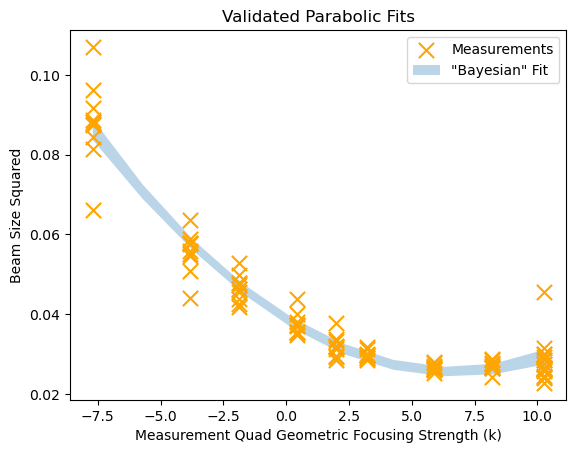

/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/emitopt/utils.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)


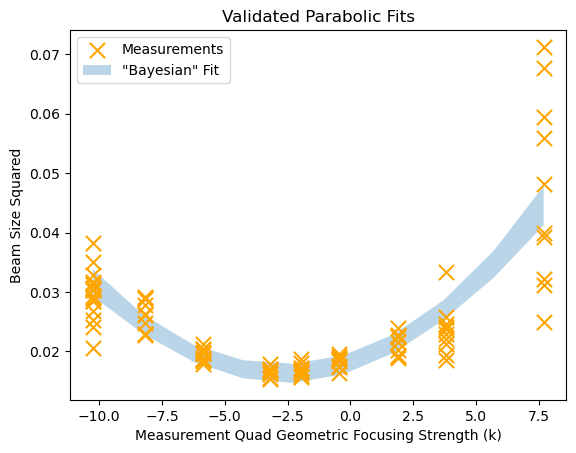

In [17]:

emit_results, emit_Xopt = characterize_emittance(
    emit_vocs,
    eval_beamsize,
    QUAD_LENGTH,
    DRIFT_LENGTH,
    BEAM_ENERGY,
    quad_strength_key=SCAN_VARIABLE,
    quad_strength_scale_factor=quad_strength_scale_factor,
    rms_x_key="S_x_mm",
    rms_y_key="S_y_mm",
    quad_scan_analysis_kwargs={"visualize": True},
    n_initial=5,
    n_iterations=5
)

In [24]:
emit_results["x_emittance_median"] * BEAM_ENERGY / 0.511e-3

0.3841061615451404

In [30]:
emit_results["y_emittance_median"] * BEAM_ENERGY / 0.511e-3

0.2911638871708618

In [25]:
emit_results

{'x_emittance_median': 0.0014539129522190125,
 'x_emittance_05': 0.0013922069879645734,
 'x_emittance_95': 0.0015116740882722354,
 'y_emittance_median': 0.0011021092321800766,
 'y_emittance_05': 0.0010557682262297894,
 'y_emittance_95': 0.00114682695668161}

In [19]:
bad_image_time = emit_Xopt.data.iloc[emit_Xopt.data["S_y_mm"].to_numpy().argmax()]["time"]

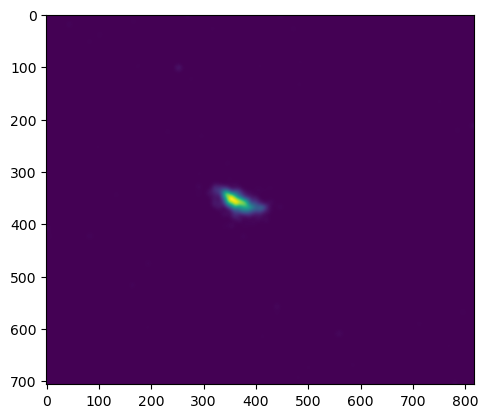

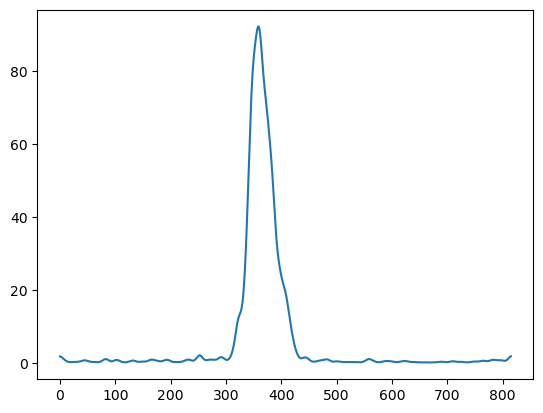

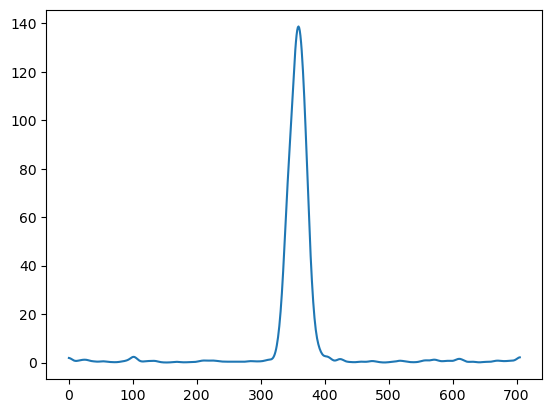

In [20]:
# load bad image
from scipy.ndimage import median_filter, gaussian_filter

res = np.load(f"{run_dir}/{bad_image_time}.npy")
res = np.where(
        res - 3 > 0, res - 3, 0
    )
res = median_filter(res, 5)
res = gaussian_filter(res, 5)

fig,ax = plt.subplots()
ax.imshow(res)

plt.figure()
plt.plot(res.sum(axis=0))

plt.figure()
plt.plot(res.sum(axis=1))

In [29]:
emit_Xopt.options.dump_file = "emittance_run_2.yml"
emit_Xopt.dump_state()

In [28]:
emit_Xopt.to_yaml()

AttributeError: 'Xopt' object has no attribute 'to_yaml'

<Axes: xlabel='QUAD:IN20:525:BCTRL'>

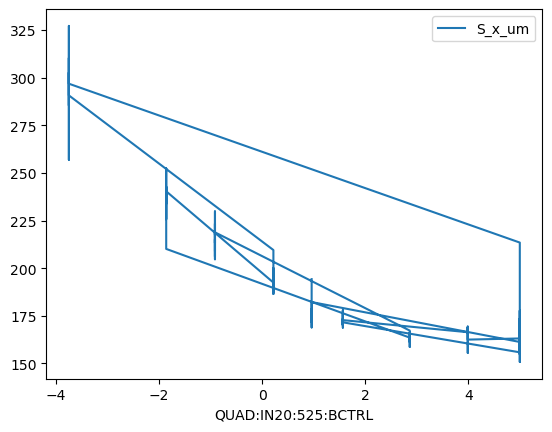

In [40]:
emit_Xopt.data["S_x_um"] = emit_Xopt.data["S_x_mm"]*1e3
emit_Xopt.data.plot(x="QUAD:IN20:525:BCTRL", y="S_x_um")